In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import layers

## Data Loading

In [2]:
batting_file = "./raw_data/international/batting.xlsx"
bowling_file = "./raw_data/international/bowling.xlsx"
matches_file = "./raw_data/international/matches.xlsx"
players_file = "./raw_data/international/players.xlsx"

In [3]:
batting_data = pd.read_parquet(batting_file[:-4]+"parquet")
bowling_data = pd.read_parquet(bowling_file[:-4]+"parquet")
matches_data = pd.read_parquet(matches_file[:-4]+"parquet")
players_data = pd.read_parquet(players_file[:-4]+"parquet")

## Preprocessing and Cleaning

In [4]:
players_data['Age'] = players_data['Age'].replace(np.nan, None)

In [5]:
ages = players_data['Age'].apply(lambda x: re.search(r'(\d*)y', x).group(1) if x is not None else '0')

ages = ages.astype(int)

players_data['Age'] = ages
players_data = players_data.drop(players_data['Age'][players_data['Age'] == 0].index).reset_index(drop=True)
players_data = players_data.drop(players_data['Age'][players_data['Age'] >= 55].index).reset_index(drop=True)



In [6]:
players_data = players_data[players_data['Playing Role'].notna()].reset_index(drop=True)

players = players_data['Player URL'].unique()

ids = np.arange(len(players))

player_ids = dict(zip(players, ids))

In [7]:
players_data['Player ID'] = players_data['Player URL'].apply(lambda x: player_ids[x])

In [8]:
batting_data['Player ID'] = batting_data['Link'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [9]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)

In [10]:
batting_data['Player ID'] = batting_data['Player ID'].astype(int)

In [11]:
bowling_data['Player ID'] = bowling_data['Link'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [12]:
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)

In [13]:
bowling_data['Player ID'] = bowling_data['Player ID'].astype(int)

In [14]:
batting_data[batting_data['Player ID'].notna()].shape, batting_data['Player ID'].shape

((23590, 18), (23590,))

In [15]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)


In [16]:
batting_data.head(5)

,Link,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/tamim-iqba...,c †Boucher b Morkel,31,67,97,5,0,46.26,Tamim Iqbal,2,c McKenzie b Morkel,20,45,67,2,0,44.44,910
1,https://www.espncricinfo.com/player/imrul-kaye...,c Smith b Ntini,6,39,61,0,0,15.38,Imrul Kayes,2,c Smith b Ntini,5,12,14,1,0,41.66,355
2,https://www.espncricinfo.com/player/junaid-sid...,c McKenzie b Ntini,67,144,195,11,0,46.52,Junaid Siddique,2,c Amla b Kallis,16,21,38,2,0,76.19,430
3,https://www.espncricinfo.com/player/mohammad-a...,c & b Morkel,1,9,13,0,0,11.11,Mohammad Ashraful,2,run out (Steyn),21,29,37,3,0,72.41,583
4,https://www.espncricinfo.com/player/mehrab-hos...,c Kallis b Ntini,3,20,30,0,0,15.00,Mehrab Hossain jnr,2,run out (Amla),0,4,10,0,0,0.00,554


In [17]:
matches_data.head(5)

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Player Replacement,Points,FC debut,Balls per over,Batsman of The Match,Bowler of The Match,Fielder of The Match,Batsman of The Series,Bowler of The Series,Fielder of The Series
0,https://www.espncricinfo.com/series/bangladesh...,2,None,"2nd Test, Centurion, November 26 - 28, 2008",South Africa won by an innings and 48 runs,https://www.espncricinfo.com/ci/content/ground...,"SuperSport Park, Centurion","Bangladesh, elected to bat first",Bangladesh tour of South Africa,2008/09,...,None,None,NaN,NaN,None,None,None,None,None,None
1,https://www.espncricinfo.com/series/bangladesh...,4,https://www.espncricinfo.com/player/martin-gup...,"Only Test, Hamilton, February 15 - 19, 2010",New Zealand won by 121 runs,https://www.espncricinfo.com/ci/content/ground...,"Seddon Park, Hamilton","Bangladesh, elected to field first",Bangladesh tour of New Zealand,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None
2,https://www.espncricinfo.com/series/england-to...,6,https://www.espncricinfo.com/player/graeme-swa...,"1st Test, Chattogram, March 12 - 16, 2010",England won by 181 runs,https://www.espncricinfo.com/ci/content/ground...,"Zahur Ahmed Chowdhury Stadium, Chittagong","Bangladesh, elected to field first",England tour of Bangladesh,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None
3,https://www.espncricinfo.com/series/bangladesh...,1,https://www.espncricinfo.com/player/brendan-ta...,"Only Test, Harare, August 04 - 08, 2011",Zimbabwe won by 130 runs,https://www.espncricinfo.com/ci/content/ground...,Harare Sports Club,"Bangladesh, elected to field first",Bangladesh tour of Zimbabwe,2011,...,None,None,NaN,NaN,None,None,None,None,None,None
4,https://www.espncricinfo.com/series/england-to...,5,None,"2nd Test, Mirpur, March 20 - 24, 2010",England won by 9 wickets,https://www.espncricinfo.com/ci/content/ground...,"Shere Bangla National Stadium, Mirpur","Bangladesh, elected to bat first",England tour of Bangladesh,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None


In [18]:
players_data.head(5)

,Player URL,Full Name,Born,Age,Batting Style,Bowling Style,Playing Role,Team URL,Team Name,Other,Nicknames,Height,Fielding Position,Died,RELATIONS,Also Known As,Education,links,Player ID
0,https://www.espncricinfo.com/player/aaqib-jave...,Aaqib Javed,"August 05, 1972, Sheikhupura, Punjab",49,Right hand Bat,Right arm Fast medium,Bowler,https://www.espncricinfo.com/team/pakistan-7,Pakistan,None,None,None,None,None,NaN,None,None,NaN,0
1,https://www.espncricinfo.com/player/aakash-cho...,Aakash Chopra,"September 19, 1977, Agra, Uttar Pradesh",44,Right hand Bat,"Right arm Medium, Right arm Offbreak",Batter,https://www.espncricinfo.com/team/india-6,India,None,None,None,None,None,NaN,None,None,NaN,1
2,https://www.espncricinfo.com/player/aaron-finc...,Aaron James Finch,"November 17, 1986, Colac, Victoria",35,Right hand Bat,Slow Left arm Orthodox,Top order Batter,https://www.espncricinfo.com/team/australia-2,Australia,None,Finchy,1.74 m,None,None,NaN,None,None,NaN,2
3,https://www.espncricinfo.com/player/ab-de-vill...,Abraham Benjamin de Villiers,"February 17, 1984, Pretoria",38,Right hand Bat,Right arm Medium,Wicketkeeper Batter,https://www.espncricinfo.com/team/south-africa-3,South Africa,None,None,None,Wicketkeeper,None,NaN,None,None,NaN,3
4,https://www.espncricinfo.com/player/aaron-redm...,Aaron James Redmond,"September 23, 1979, Auckland",42,Right hand Bat,Legbreak,Top order Batter,https://www.espncricinfo.com/team/new-zealand-5,New Zealand,None,None,None,Occasional Wicketkeeper,None,NaN,None,None,NaN,4


## Process batting data

In [19]:
batting_data["Wicket"] = batting_data["Wicket"].fillna("didnt play")
wickets = batting_data["Wicket"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets = wickets.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets = wickets.apply(lambda x: x.strip())

batting_data["Wicket"] = wickets

In [20]:
batting_data.columns

Index(['Link', 'Wicket', 'R', 'B', 'M', '4s', '6s', 'SR', 'Player Name',
       'Match ID', 'Wicket_2', 'R_2', 'B_2', 'M_2', '4s_2', '6s_2', 'SR_2',
       'Player ID'],
      dtype='object')

In [21]:
batting_data["Wicket_2"] = batting_data["Wicket_2"].fillna("didnt play")

wickets_2 = batting_data["Wicket_2"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets_2 = wickets_2.apply(lambda x: x.strip())

batting_data["Wicket_2"] = wickets_2

In [22]:
batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']] = batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']].replace('-', 0).astype(np.float32)

In [23]:
batting_data

,Link,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/tamim-iqba...,c,31.0,67.0,97.0,5.0,0.0,46.259998,Tamim Iqbal,2,c,20.0,45.0,67.0,2.0,0.0,44.439999,910
1,https://www.espncricinfo.com/player/imrul-kaye...,c,6.0,39.0,61.0,0.0,0.0,15.380000,Imrul Kayes,2,c,5.0,12.0,14.0,1.0,0.0,41.660000,355
2,https://www.espncricinfo.com/player/junaid-sid...,c,67.0,144.0,195.0,11.0,0.0,46.520000,Junaid Siddique,2,c,16.0,21.0,38.0,2.0,0.0,76.190002,430
3,https://www.espncricinfo.com/player/mohammad-a...,c,1.0,9.0,13.0,0.0,0.0,11.110000,Mohammad Ashraful,2,run out,21.0,29.0,37.0,3.0,0.0,72.410004,583
4,https://www.espncricinfo.com/player/mehrab-hos...,c,3.0,20.0,30.0,0.0,0.0,15.000000,Mehrab Hossain jnr,2,run out,0.0,4.0,10.0,0.0,0.0,0.000000,554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23585,https://www.espncricinfo.com/player/grant-flow...,c,84.0,218.0,266.0,5.0,2.0,38.529999,Grant Flower,2374,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,305
23586,https://www.espncricinfo.com/player/heath-stre...,c,87.0,164.0,264.0,8.0,1.0,53.040001,Heath Streak,2374,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,329
23587,https://www.espncricinfo.com/player/andy-blign...,b,15.0,26.0,24.0,1.0,0.0,57.689999,Andy Blignaut,2374,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,72
23588,https://www.espncricinfo.com/player/mluleki-nk...,c,7.0,11.0,17.0,0.0,1.0,63.630001,Mluleki Nkala,2374,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,582


In [24]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = batting_data.select_dtypes(include=numerics).columns

batting_data[num_cols] = batting_data[num_cols].fillna(0)

batting_data

,Link,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/tamim-iqba...,c,31.0,67.0,97.0,5.0,0.0,46.259998,Tamim Iqbal,2,c,20.0,45.0,67.0,2.0,0.0,44.439999,910
1,https://www.espncricinfo.com/player/imrul-kaye...,c,6.0,39.0,61.0,0.0,0.0,15.380000,Imrul Kayes,2,c,5.0,12.0,14.0,1.0,0.0,41.660000,355
2,https://www.espncricinfo.com/player/junaid-sid...,c,67.0,144.0,195.0,11.0,0.0,46.520000,Junaid Siddique,2,c,16.0,21.0,38.0,2.0,0.0,76.190002,430
3,https://www.espncricinfo.com/player/mohammad-a...,c,1.0,9.0,13.0,0.0,0.0,11.110000,Mohammad Ashraful,2,run out,21.0,29.0,37.0,3.0,0.0,72.410004,583
4,https://www.espncricinfo.com/player/mehrab-hos...,c,3.0,20.0,30.0,0.0,0.0,15.000000,Mehrab Hossain jnr,2,run out,0.0,4.0,10.0,0.0,0.0,0.000000,554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23585,https://www.espncricinfo.com/player/grant-flow...,c,84.0,218.0,266.0,5.0,2.0,38.529999,Grant Flower,2374,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,305
23586,https://www.espncricinfo.com/player/heath-stre...,c,87.0,164.0,264.0,8.0,1.0,53.040001,Heath Streak,2374,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,329
23587,https://www.espncricinfo.com/player/andy-blign...,b,15.0,26.0,24.0,1.0,0.0,57.689999,Andy Blignaut,2374,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,72
23588,https://www.espncricinfo.com/player/mluleki-nk...,c,7.0,11.0,17.0,0.0,1.0,63.630001,Mluleki Nkala,2374,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,582


## Process matches data

In [25]:
match_ids = batting_data['Match ID'].unique()
match_ids = np.unique(np.concatenate((match_ids, bowling_data['Match ID'].unique())))

match_ids

array([   1,    2,    3, ..., 2374, 2375, 2376], dtype=int64)

In [26]:
matches_data = matches_data[matches_data['Match ID'].apply(lambda x: x in match_ids)].reset_index(drop=True)

In [27]:
matches_data

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Player Replacement,Points,FC debut,Balls per over,Batsman of The Match,Bowler of The Match,Fielder of The Match,Batsman of The Series,Bowler of The Series,Fielder of The Series
0,https://www.espncricinfo.com/series/bangladesh...,2,None,"2nd Test, Centurion, November 26 - 28, 2008",South Africa won by an innings and 48 runs,https://www.espncricinfo.com/ci/content/ground...,"SuperSport Park, Centurion","Bangladesh, elected to bat first",Bangladesh tour of South Africa,2008/09,...,None,None,NaN,NaN,None,None,None,None,None,None
1,https://www.espncricinfo.com/series/bangladesh...,4,https://www.espncricinfo.com/player/martin-gup...,"Only Test, Hamilton, February 15 - 19, 2010",New Zealand won by 121 runs,https://www.espncricinfo.com/ci/content/ground...,"Seddon Park, Hamilton","Bangladesh, elected to field first",Bangladesh tour of New Zealand,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None
2,https://www.espncricinfo.com/series/england-to...,6,https://www.espncricinfo.com/player/graeme-swa...,"1st Test, Chattogram, March 12 - 16, 2010",England won by 181 runs,https://www.espncricinfo.com/ci/content/ground...,"Zahur Ahmed Chowdhury Stadium, Chittagong","Bangladesh, elected to field first",England tour of Bangladesh,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None
3,https://www.espncricinfo.com/series/bangladesh...,1,https://www.espncricinfo.com/player/brendan-ta...,"Only Test, Harare, August 04 - 08, 2011",Zimbabwe won by 130 runs,https://www.espncricinfo.com/ci/content/ground...,Harare Sports Club,"Bangladesh, elected to field first",Bangladesh tour of Zimbabwe,2011,...,None,None,NaN,NaN,None,None,None,None,None,None
4,https://www.espncricinfo.com/series/england-to...,5,None,"2nd Test, Mirpur, March 20 - 24, 2010",England won by 9 wickets,https://www.espncricinfo.com/ci/content/ground...,"Shere Bangla National Stadium, Mirpur","Bangladesh, elected to bat first",England tour of Bangladesh,2009/10,...,None,None,NaN,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,https://www.espncricinfo.com/series/asian-test...,2372,https://www.espncricinfo.com/player/muthiah-mu...,"2nd Match, Colombo (SSC), September 06 - 08, 2001",Sri Lanka won by an innings and 137 runs,https://www.espncricinfo.com/ci/content/ground...,"Sinhalese Sports Club Ground, Colombo","Sri Lanka, elected to field first",Asian Test Championship,2001,...,None,"Sri Lanka 24, Bangladesh 0",NaN,NaN,None,None,None,None,None,None
1345,https://www.espncricinfo.com/series/asian-test...,2373,https://www.espncricinfo.com/player/danish-kan...,"1st Match, Multan, August 29 - 31, 2001",Pakistan won by an innings and 264 runs,https://www.espncricinfo.com/ci/content/ground...,Multan Cricket Stadium,"Bangladesh, elected to bat first",Asian Test Championship,2001,...,None,"Pakistan 24, Bangladesh 0",NaN,NaN,None,None,None,None,None,None
1346,https://www.espncricinfo.com/series/india-tour...,2376,https://www.espncricinfo.com/player/sunil-josh...,"Only Test, Dhaka, November 10 - 13, 2000",India won by 9 wickets,https://www.espncricinfo.com/ci/content/ground...,"Bangabandhu National Stadium, Dhaka","Bangladesh, elected to bat first",India tour of Bangladesh,2000/01,...,None,None,NaN,NaN,None,None,None,None,None,None
1347,https://www.espncricinfo.com/series/bangladesh...,2375,https://www.espncricinfo.com/player/javed-omar...,"1st Test, Bulawayo, April 19 - 22, 2001",Zimbabwe won by an innings and 32 runs,https://www.espncricinfo.com/ci/content/ground...,"Queens Sports Club, Bulawayo","Zimbabwe, elected to field first",Bangladesh tour of Zimbabwe,2000/01,...,None,None,NaN,NaN,None,None,None,None,None,None


In [28]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [29]:
results = matches_data['Result'].apply(lambda x: re.match(r'(.*) won.*', x).group(1) if re.match(r'.* won.*', x) else x)
results = results.apply(lambda x: 'Draw' if x.strip() == "Match drawn" else x)
results = results.apply(lambda x: None if re.match(r'.*refused.*', x) else x)

In [30]:
matches_data['Result'] = results

In [31]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [32]:
matches_data['MoM'] = matches_data['MoM'].apply(lambda x: player_ids[x] if x in player_ids.keys() else None)

In [33]:
matches_data['Meta']

0             2nd Test, Centurion, November 26 - 28, 2008
1             Only Test, Hamilton, February 15 - 19, 2010
2               1st Test, Chattogram, March 12 - 16, 2010
3                 Only Test, Harare, August 04 - 08, 2011
4                   2nd Test, Mirpur, March 20 - 24, 2010
                              ...                        
1343    2nd Match, Colombo (SSC), September 06 - 08, 2001
1344              1st Match, Multan, August 29 - 31, 2001
1345             Only Test, Dhaka, November 10 - 13, 2000
1346              1st Test, Bulawayo, April 19 - 22, 2001
1347                2nd Test, Harare, April 26 - 30, 2001
Name: Meta, Length: 1348, dtype: object

In [34]:
str_dates = matches_data['Meta'].apply(lambda x: re.match(r'.*?,.*?,(.*)', x).group(1))

In [35]:
re_dates = str_dates.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - \d\d, (\d\d\d\d)', x) if re.match(r' \w.* \d\d - \d\d, \d\d\d\d', x) else x)
dates_1 = re_dates.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [36]:
re_dates_2 = dates_1.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d) - .*', x) else x)
dates_2 = re_dates_2.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [37]:
re_dates_3 = dates_2.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) else x)
dates_3 = re_dates_3.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [38]:
matches_data['Date'] = dates_3.apply(lambda x: datetime.strptime(x, "%B,%d,%Y") )

In [39]:
matches_data['Toss Won'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[0])

In [40]:
matches_data = matches_data[matches_data['Toss'] != 'no toss'].reset_index(drop=True)

In [41]:
matches_data['Toss Selection'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[1].split(' ')[3])

In [42]:
matches_data.to_excel("results/international/matches.xlsx", index=False)

In [43]:
players_data.to_excel("results/international/players.xlsx", index=False)

['Allrounder' 'Batter' 'Batting Allrounder' 'Bowler' 'Bowling Allrounder'
 'Middle order Batter' 'Opening Batter' 'Top order Batter' 'Wicketkeeper'
 'Wicketkeeper Batter']


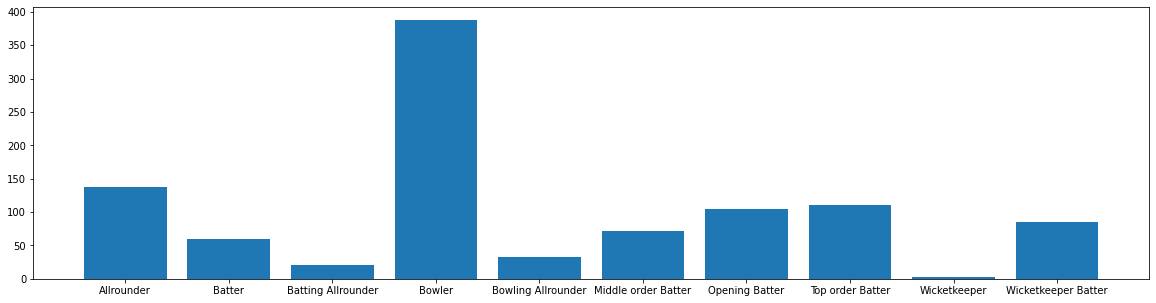

In [44]:
roles, counts = np.unique(players_data['Playing Role'], return_counts=True)

plt.figure(figsize=(20, 5)), plt.bar(roles, counts)
print(roles)

In [45]:
role_data = {}
batting_roles = roles[roles != "Bowler"]
for role in batting_roles:
    ids = players_data[players_data['Playing Role'].apply(lambda x: x == role)]['Player ID'].values
    count = batting_data['Player ID'].apply(lambda x: x in ids).values.sum()
    role_data[role] = count
    
    


(<Figure size 1440x360 with 1 Axes>, <BarContainer object of 9 artists>)

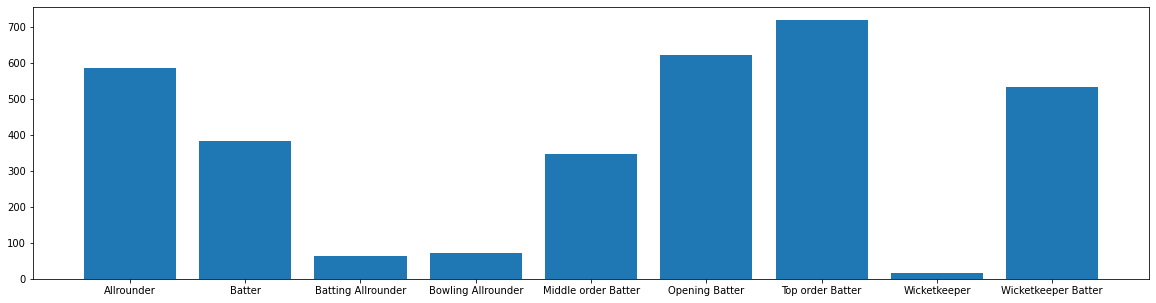

In [46]:
plt.figure(figsize=(20, 5)), plt.bar(role_data.keys(), np.array(list(role_data.values()))//5)


In [47]:
player_nationalities = {}
for i in range(len(players_data)):
    player_nationalities[players_data.iloc[i]['Player ID']] = players_data.iloc[i]['Team Name']

In [48]:
json_data = dict()
for k, v in player_nationalities.items():
    json_data[str(k)] = v

In [49]:
with open("results/international/player_nationalities.json", "w") as fp:
    json.dump(json_data, fp)

In [50]:
match_results = {}
for i in range(len(matches_data)):
    match_results[matches_data.iloc[i]['Match ID']] = [matches_data.iloc[i]['Result'], matches_data.iloc[i]['MoM'], matches_data.iloc[i]['Date'], matches_data.iloc[i]['Toss Won'], matches_data.iloc[i]['Toss Selection']]


## Batsman Model

In [51]:
batting_data['Team'] = "None"
batting_data['Team'] = batting_data['Player ID'].apply(lambda x: player_nationalities[x])

In [52]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [53]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [54]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [55]:
def hundred_1(row):
     if row['R'] >= 100:
        return 1
     if row['R'] < 100:
        return 0
     return 'None'

In [56]:
def hundred_2(row):
     if row['R_2'] >= 100:
        return 1
     if row['R_2'] < 100:
        return 0
     return 'None'

In [57]:
def fifty_1(row):
     if row['R'] >= 50 or row['R'] < 100:
        return 1
     if row['R'] < 50 or row['R'] >= 100:
        return 0
     return 'None'  

In [58]:
def fifty_2(row):
     if row['R_2'] >= 50 or row['R_2'] < 100:
        return 1
     if row['R_2'] < 50 or row['R_2'] >=100:
        return 0
     return 'None'

In [59]:
batting_data['H'] = batting_data.apply(lambda row: hundred_1(row), axis=1)

In [60]:
batting_data['H_2'] = batting_data.apply(lambda row: hundred_2(row), axis=1)

In [61]:
batting_data['F'] = batting_data.apply(lambda row: fifty_1(row), axis=1)

In [62]:
batting_data['F_2'] = batting_data.apply(lambda row: fifty_2(row), axis=1)

In [63]:
batting_data['Result'] = batting_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [64]:
batting_data = batting_data[batting_data['Result'].notna()].reset_index(drop=True)

In [65]:
batting_data['MoM'] = batting_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [66]:
batting_data = batting_data[batting_data['MoM'].notna()].reset_index(drop=True)

In [67]:
batting_data['Chase'] = batting_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [68]:
batting_data = batting_data[batting_data['Chase'].notna()].reset_index(drop=True)

In [69]:
batting_data['Date'] = batting_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [70]:
batting_data = batting_data[batting_data['Date'].notna()].reset_index(drop=True)

In [71]:
batting_data.to_excel("results/international/batting.xlsx", index=False)

In [72]:
bat_X = batting_data[['Player ID', 'Date', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', '4s', '6s', 'SR', 'R_2', 'B_2', '4s_2', '6s_2', 'SR_2']].copy()

In [73]:
mm = MinMaxScaler()
bat_X.iloc[:, 6:] = mm.fit_transform(bat_X.iloc[:,6:])

In [74]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bat_X['Result Label'] = bat_X['Result'].apply(lambda x: result_dict[x])
bat_X

,Player ID,Date,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,...,B,4s,6s,SR,R_2,B_2,4s_2,6s_2,SR_2,Result Label
0,910,2008-11-26,c,c,0,Lost,0.0,0.0,0.0,0.0,...,0.115120,0.106383,0.000000,0.115650,0.066225,0.070093,0.045455,0.0,0.074067,0
1,355,2008-11-26,c,c,0,Lost,0.0,0.0,0.0,0.0,...,0.067010,0.000000,0.000000,0.038450,0.016556,0.018692,0.022727,0.0,0.069433,0
2,430,2008-11-26,c,c,0,Lost,0.0,0.0,0.0,0.0,...,0.247423,0.234043,0.000000,0.116300,0.052980,0.032710,0.045455,0.0,0.126983,0
3,583,2008-11-26,c,run out,0,Lost,0.0,0.0,0.0,0.0,...,0.015464,0.000000,0.000000,0.027775,0.069536,0.045171,0.068182,0.0,0.120683,0
4,554,2008-11-26,c,run out,0,Lost,0.0,0.0,0.0,0.0,...,0.034364,0.000000,0.000000,0.037500,0.000000,0.006231,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23563,305,2001-04-26,c,didnt play,1,Won,0.0,0.0,0.0,0.0,...,0.374570,0.106383,0.181818,0.096325,0.000000,0.000000,0.000000,0.0,0.000000,2
23564,329,2001-04-26,c,didnt play,1,Won,0.0,0.0,0.0,0.0,...,0.281787,0.170213,0.090909,0.132600,0.000000,0.000000,0.000000,0.0,0.000000,2
23565,72,2001-04-26,b,didnt play,1,Won,0.0,0.0,0.0,0.0,...,0.044674,0.021277,0.000000,0.144225,0.000000,0.000000,0.000000,0.0,0.000000,2
23566,582,2001-04-26,c,didnt play,1,Won,0.0,0.0,0.0,0.0,...,0.018900,0.000000,0.090909,0.159075,0.000000,0.000000,0.000000,0.0,0.000000,2


In [75]:
runs_factor = 0.7
mom_factor = 0.075
hundred_factor = 0.075
chase_factor = 0.05
fifties_factor = 0.035
win_factor = 0.025
not_out_factor = 0.025
sr_factor = 0.015

In [76]:
bat_X['Rating'] = bat_X['Chase'] * chase_factor + bat_X['F'] * fifties_factor + bat_X['F_2'] * fifties_factor + bat_X['H'] * hundred_factor + bat_X['H_2'] * hundred_factor + bat_X['MoM'] * mom_factor + bat_X['Result Label'] * win_factor +  bat_X['R'] * runs_factor + bat_X['R_2'] * runs_factor + bat_X['SR'] * sr_factor + bat_X['SR_2'] * sr_factor + (bat_X['Wicket'] == 'not out').astype(float) * not_out_factor + (bat_X['Wicket_2'] == 'not out').astype(float) * not_out_factor 

In [77]:
batting_data['Rating'] = bat_X['Rating']

In [78]:
test = batting_data[batting_data['Player Name'] == 'Babar Azam'].sort_values(by='Date')

In [79]:
test[['Rating', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', 'SR', 'R_2', 'B_2', 'SR_2']].sort_values(by='Rating', ascending=False)

,Rating,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,F_2,R,B,SR,R_2,B_2,SR_2
3891,0.745166,c,c,1,Draw,1,0,1,1,1,36.0,79.0,45.560001,196.0,425.0,46.110001
892,0.491040,b,not out,0,Won,0,0,1,1,1,60.0,96.0,62.500000,100.0,131.0,76.330002
21717,0.428028,c,didnt play,1,Won,0,1,0,1,1,143.0,193.0,74.089996,0.0,0.0,0.000000
10619,0.374060,not out,didnt play,0,Won,0,1,0,1,1,127.0,263.0,48.279999,0.0,0.0,0.000000
922,0.356488,not out,didnt play,1,Draw,0,1,0,1,1,102.0,128.0,79.680000,0.0,0.0,0.000000
4460,0.320250,c,c,0,Lost,0,0,1,1,1,1.0,4.0,25.000000,104.0,173.0,60.110001
3996,0.297973,b,c,1,Lost,0,0,0,1,1,67.0,131.0,51.139999,55.0,104.0,52.880001
4439,0.280917,b,b,0,Won,0,0,0,1,1,0.0,2.0,0.000000,99.0,171.0,57.889999
2554,0.274227,b,not out,1,Won,0,0,0,1,1,72.0,201.0,35.820000,9.0,22.0,40.900002
10770,0.272908,not out,b,1,Lost,0,0,0,1,1,90.0,196.0,45.910000,16.0,25.0,64.000000


In [80]:
test_2 = batting_data[batting_data['Player Name'] == 'Usman Khawaja'].sort_values(by='Date')

In [81]:
test_2[['Rating', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', 'SR', 'R_2', 'B_2', 'SR_2']].sort_values(by='Rating', ascending=False)

,Rating,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,F_2,R,B,SR,R_2,B_2,SR_2
5983,0.752661,b,not out,0,Draw,1,1,1,1,1,137.0,260.0,52.689999,101.0,138.0,73.180000
4489,0.703560,c,b,1,Draw,1,0,1,1,1,85.0,175.0,48.570000,141.0,302.0,46.680000
3983,0.553328,c,not out,0,Won,0,0,1,1,1,91.0,219.0,41.549999,104.0,178.0,58.419998
4361,0.511475,c,c,0,Won,0,1,0,1,1,144.0,227.0,63.430000,56.0,61.0,91.800003
3878,0.510184,b,not out,0,Draw,0,1,0,1,1,160.0,369.0,43.360001,44.0,70.0,62.849998
10825,0.480136,c,not out,0,Won,0,1,0,1,1,174.0,239.0,72.800003,9.0,11.0,81.809998
6924,0.475933,b,didnt play,1,Won,0,1,0,1,1,171.0,381.0,44.880001,0.0,0.0,0.000000
8829,0.430515,b,b,1,Won,0,1,0,1,1,145.0,308.0,47.070000,0.0,2.0,0.000000
10605,0.422430,b,didnt play,1,Won,0,1,0,1,1,140.0,216.0,64.809998,0.0,0.0,0.000000
4604,0.385962,c,not out,0,Won,0,0,1,1,1,0.0,3.0,0.000000,101.0,136.0,74.260002


In [82]:
del bat_X['Result']

In [83]:
le_1 = LabelEncoder()
bat_X['Wicket'] = le_1.fit_transform(bat_X['Wicket'])
le_2 = LabelEncoder()
bat_X['Wicket_2'] = le_2.fit_transform(bat_X['Wicket_2'])

In [84]:
bat_X = pd.concat((bat_X, pd.get_dummies(bat_X['Wicket_2'], prefix="Wicket2")), axis=1)

In [85]:
del bat_X['Wicket']
del bat_X['Wicket_2']

In [86]:
bat_X.to_csv("results/international/traindata_batting.csv", index=False)

## Training

In [87]:
sequence_length = 10

In [88]:
train_data = []
counts = []
for player_id, indices in bat_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [89]:
train_data = [[bat_X.loc[idx[:-1]].iloc[:, 2:].values, bat_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [90]:
x = np.array([t[0] for t in train_data])

In [91]:
y = np.array([t[1] for t in train_data])

In [92]:
y_cats = np.digitize(y, np.arange(0,np.max(y) + np.min(y), 0.1))

In [93]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([687, 774, 241, 115,  59,  38,  20,  13,   3], dtype=int64))

In [94]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [95]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([687, 774, 241, 115,  59,  38,  20,  13,   3], dtype=int64))

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [97]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [98]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [99]:
y_train_cats, y_train_counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([481, 542, 169,  80,  41,  27,  14,   9,   2], dtype=int64))

In [100]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(2, 542)

In [101]:
y_train_labels.flatten()

array([2, 2, 1, ..., 3, 2, 1], dtype=int64)

In [102]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [103]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [104]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 256)            290816    
                                                                 
 lstm_1 (LSTM)               (None, 9, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 549,793
Trainable params: 549,793
Non-trainable params: 0
_________________________________________________________________


In [105]:
save_best = keras.callbacks.ModelCheckpoint("./results/international/batting.h5", save_best_only=True)

In [106]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
136/136 [==============================] - 38s 119ms/step - loss: 0.1458 - val_loss: 0.1879
Epoch 2/500
136/136 [==============================] - 11s 84ms/step - loss: 0.0908 - val_loss: 0.1473
Epoch 3/500
136/136 [==============================] - 11s 79ms/step - loss: 0.0710 - val_loss: 0.1648
Epoch 4/500
136/136 [==============================] - 11s 79ms/step - loss: 0.0546 - val_loss: 0.1409
Epoch 5/500
136/136 [==============================] - 11s 81ms/step - loss: 0.0501 - val_loss: 0.1443
Epoch 6/500
136/136 [==============================] - 12s 86ms/step - loss: 0.0396 - val_loss: 0.1368
Epoch 7/500
136/136 [==============================] - 12s 88ms/step - loss: 0.0347 - val_loss: 0.1313
Epoch 8/500
136/136 [==============================] - 12s 88ms/step - loss: 0.0310 - val_loss: 0.1307
Epoch 9/500
136/136 [==============================] - 13s 95ms/step - loss: 0.0277 - val_loss: 0.1325
Epoch 10/500
136/136 [==============================] - 12s 88ms/step - 

Epoch 80/500
136/136 [==============================] - 12s 89ms/step - loss: 0.0038 - val_loss: 0.1072
Epoch 81/500
136/136 [==============================] - 12s 85ms/step - loss: 0.0039 - val_loss: 0.1149
Epoch 82/500
136/136 [==============================] - 11s 82ms/step - loss: 0.0040 - val_loss: 0.1100
Epoch 83/500
136/136 [==============================] - 11s 82ms/step - loss: 0.0039 - val_loss: 0.1108
Epoch 84/500
136/136 [==============================] - 11s 82ms/step - loss: 0.0040 - val_loss: 0.1122
Epoch 85/500
136/136 [==============================] - 10s 77ms/step - loss: 0.0043 - val_loss: 0.1193
Epoch 86/500
136/136 [==============================] - 10s 75ms/step - loss: 0.0050 - val_loss: 0.1138
Epoch 87/500
136/136 [==============================] - 10s 76ms/step - loss: 0.0039 - val_loss: 0.1133
Epoch 88/500
136/136 [==============================] - 9s 67ms/step - loss: 0.0040 - val_loss: 0.1143
Epoch 89/500
136/136 [==============================] - 10s 73ms/

136/136 [==============================] - 11s 78ms/step - loss: 0.0020 - val_loss: 0.1121
Epoch 159/500
136/136 [==============================] - 10s 76ms/step - loss: 0.0021 - val_loss: 0.1131
Epoch 160/500
136/136 [==============================] - 12s 87ms/step - loss: 0.0020 - val_loss: 0.1116
Epoch 161/500
136/136 [==============================] - 10s 76ms/step - loss: 0.0019 - val_loss: 0.1115
Epoch 162/500
136/136 [==============================] - 10s 76ms/step - loss: 0.0019 - val_loss: 0.1129
Epoch 163/500
136/136 [==============================] - 10s 71ms/step - loss: 0.0022 - val_loss: 0.1107
Epoch 164/500
136/136 [==============================] - 10s 75ms/step - loss: 0.0020 - val_loss: 0.1131
Epoch 165/500
136/136 [==============================] - 12s 89ms/step - loss: 0.0018 - val_loss: 0.1099
Epoch 166/500
136/136 [==============================] - 11s 79ms/step - loss: 0.0020 - val_loss: 0.1136
Epoch 167/500
136/136 [==============================] - 10s 74ms/ste

136/136 [==============================] - 5s 36ms/step - loss: 0.0017 - val_loss: 0.1101
Epoch 237/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0015 - val_loss: 0.1124
Epoch 238/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0015 - val_loss: 0.1134
Epoch 239/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0016 - val_loss: 0.1124
Epoch 240/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0014 - val_loss: 0.1122
Epoch 241/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0014 - val_loss: 0.1116
Epoch 242/500
136/136 [==============================] - 5s 35ms/step - loss: 0.0014 - val_loss: 0.1124
Epoch 243/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0014 - val_loss: 0.1103
Epoch 244/500
136/136 [==============================] - 5s 36ms/step - loss: 0.0014 - val_loss: 0.1133
Epoch 245/500
136/136 [==============================] - 5s 36ms/step - loss: 

Epoch 315/500
136/136 [==============================] - 6s 41ms/step - loss: 0.0012 - val_loss: 0.1134
Epoch 316/500
136/136 [==============================] - 6s 41ms/step - loss: 0.0010 - val_loss: 0.1142
Epoch 317/500
136/136 [==============================] - 6s 43ms/step - loss: 0.0012 - val_loss: 0.1115
Epoch 318/500
136/136 [==============================] - 6s 41ms/step - loss: 0.0013 - val_loss: 0.1113
Epoch 319/500
136/136 [==============================] - 6s 42ms/step - loss: 0.0011 - val_loss: 0.1142
Epoch 320/500
136/136 [==============================] - 6s 42ms/step - loss: 0.0011 - val_loss: 0.1125
Epoch 321/500
136/136 [==============================] - 6s 42ms/step - loss: 0.0010 - val_loss: 0.1118
Epoch 322/500
136/136 [==============================] - 6s 42ms/step - loss: 0.0010 - val_loss: 0.1131
Epoch 323/500
136/136 [==============================] - 6s 44ms/step - loss: 0.0011 - val_loss: 0.1113
Epoch 324/500
136/136 [==============================] - 6s 42ms

136/136 [==============================] - 6s 43ms/step - loss: 8.5677e-04 - val_loss: 0.1132
Epoch 393/500
136/136 [==============================] - 6s 43ms/step - loss: 8.5267e-04 - val_loss: 0.1145
Epoch 394/500
136/136 [==============================] - 6s 43ms/step - loss: 0.0010 - val_loss: 0.1130
Epoch 395/500
136/136 [==============================] - 6s 44ms/step - loss: 0.0010 - val_loss: 0.1145
Epoch 396/500
136/136 [==============================] - 6s 43ms/step - loss: 8.2241e-04 - val_loss: 0.1114
Epoch 397/500
136/136 [==============================] - 6s 44ms/step - loss: 9.5754e-04 - val_loss: 0.1125
Epoch 398/500
136/136 [==============================] - 6s 42ms/step - loss: 9.5510e-04 - val_loss: 0.1115
Epoch 399/500
136/136 [==============================] - 6s 43ms/step - loss: 9.8557e-04 - val_loss: 0.1109
Epoch 400/500
136/136 [==============================] - 6s 43ms/step - loss: 9.8509e-04 - val_loss: 0.1125
Epoch 401/500
136/136 [===========================

136/136 [==============================] - 6s 44ms/step - loss: 8.3860e-04 - val_loss: 0.1121
Epoch 469/500
136/136 [==============================] - 6s 44ms/step - loss: 7.0415e-04 - val_loss: 0.1125
Epoch 470/500
136/136 [==============================] - 6s 44ms/step - loss: 7.2599e-04 - val_loss: 0.1130
Epoch 471/500
136/136 [==============================] - 6s 46ms/step - loss: 6.7764e-04 - val_loss: 0.1127
Epoch 472/500
136/136 [==============================] - 6s 44ms/step - loss: 7.4741e-04 - val_loss: 0.1127
Epoch 473/500
136/136 [==============================] - 6s 45ms/step - loss: 6.7122e-04 - val_loss: 0.1125
Epoch 474/500
136/136 [==============================] - 6s 44ms/step - loss: 8.0821e-04 - val_loss: 0.1128
Epoch 475/500
136/136 [==============================] - 6s 45ms/step - loss: 7.9609e-04 - val_loss: 0.1123
Epoch 476/500
136/136 [==============================] - 6s 44ms/step - loss: 7.8721e-04 - val_loss: 0.1129
Epoch 477/500
136/136 [===================

In [107]:
model = keras.models.load_model("./results/international/batting.h5")

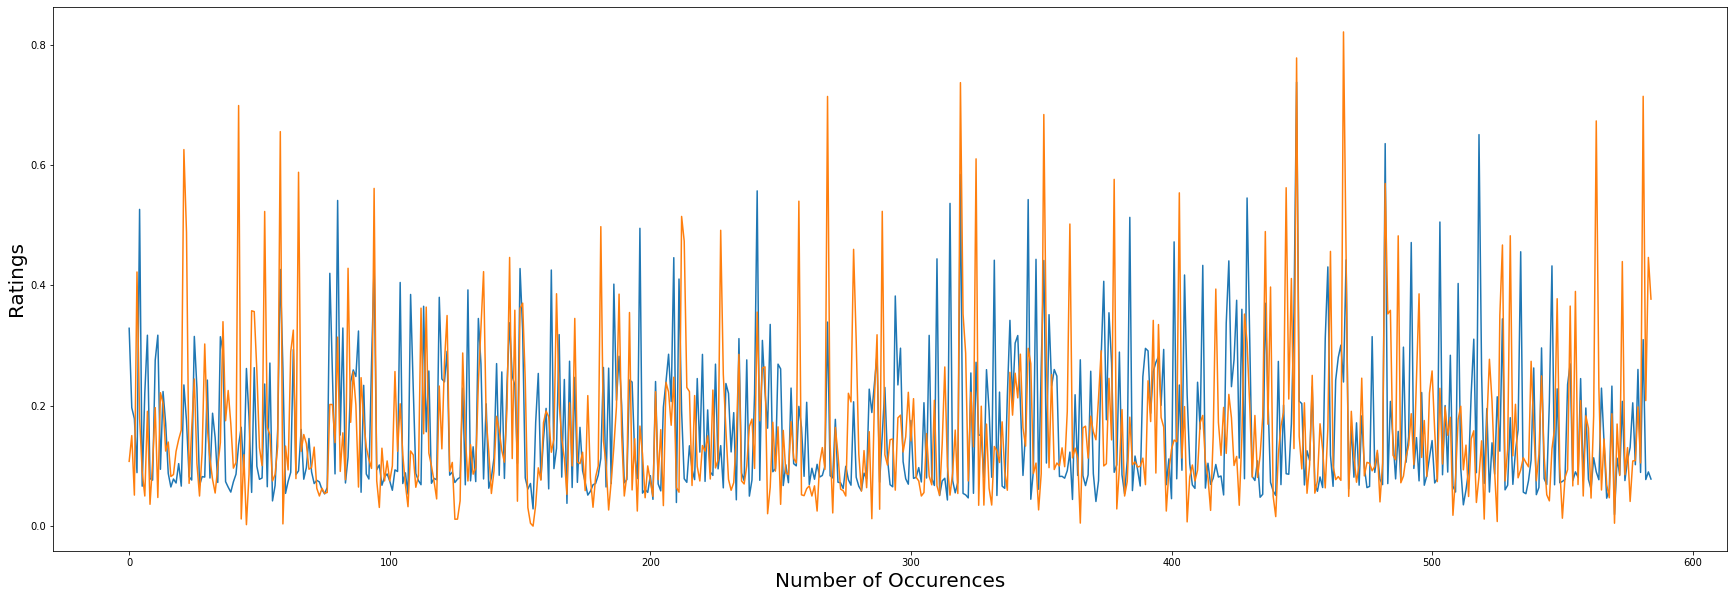

In [108]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calculating the MSE of International Batting model

In [109]:
from sklearn.metrics import mean_squared_error
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test) 

In [110]:
print('MSE of International batting model is', mse)

MSE of International batting model is 0.022832705


## Bowling Model

In [111]:
bowling_data['Team'] = "None"
bowling_data['Team'] = bowling_data['Player ID'].apply(lambda x: player_nationalities[x])

In [112]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [113]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [114]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [115]:
bowling_data['10_W'] = bowling_data['W'] + bowling_data['W_2']

In [116]:
def ten_haul(row):
    if row['10_W'] >= 10:
        return 1
    if row['10_W'] < 10:
        return 0

In [117]:
def fivehaul_1(row):
     if row['W'] >= 5:
        return 1
     if row['W'] < 5:
        return 0
     return 0

In [118]:
def fivehaul_2(row):
     if row['W_2'] >= 5:
        return 1
     if row['W_2'] < 5:
        return 0
     return 0

In [119]:
bowling_data['10_Haul'] = bowling_data.apply(lambda row: ten_haul(row), axis=1)

In [120]:
bowling_data['5H'] = bowling_data.apply(lambda row: fivehaul_1(row), axis=1)

In [121]:
bowling_data['5H_2'] = bowling_data.apply(lambda row: fivehaul_2(row), axis=1)

In [122]:
bowling_data['Result'] = bowling_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [123]:
bowling_data = bowling_data[bowling_data['Result'].notna()].reset_index(drop=True)

In [124]:
bowling_data['MoM'] = bowling_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [125]:
bowling_data = bowling_data[bowling_data['MoM'].notna()].reset_index(drop=True)

In [126]:
bowling_data['Chase'] = bowling_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [127]:
bowling_data = bowling_data[bowling_data['Chase'].notna()].reset_index(drop=True)

In [128]:
bowling_data['Date'] = bowling_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [129]:
bowling_data = bowling_data[bowling_data['Date'].notna()].reset_index(drop=True)

In [130]:
bowling_data.columns

Index(['Link', 'O', 'M', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB',
       'Player Name', 'Match ID', 'O_2', 'M_2', 'R_2', 'W_2', 'ECON_2', '0s_2',
       '4s_2', '6s_2', 'WD_2', 'NB_2', 'Player ID', 'Team', '10_W', '10_Haul',
       '5H', '5H_2', 'Result', 'MoM', 'Chase', 'Date'],
      dtype='object')

In [131]:
bowling_data.to_excel("results/international/bowling.xlsx", index=False)

In [132]:
bowl_X = bowling_data.copy()
del bowl_X['Player Name']
del bowl_X['Team']
del bowl_X['Link']

In [133]:
bowl_X = bowl_X.loc[:, ['Player ID', 'Date', 'Result',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB', 'O_2', 'R_2', 'W_2', 'ECON_2', '0s_2', '4s_2',
       '6s_2', 'WD_2', 'NB_2', ]]

In [134]:
bowl_X = bowl_X.fillna(0)

In [135]:
bowl_X['0s_2'] = bowl_X['0s_2'].replace('-', 0)
bowl_X['0s_2'] = bowl_X['0s_2'].astype(int)
bowl_X['0s'] = bowl_X['0s'].replace('-', 0)
bowl_X['0s'] = bowl_X['0s'].astype(int)

bowl_X['4s_2'] = bowl_X['4s_2'].replace('-', 0)
bowl_X['4s_2'] = bowl_X['4s_2'].astype(int)
bowl_X['4s'] = bowl_X['4s'].replace('-', 0)
bowl_X['4s'] = bowl_X['4s'].astype(int)

bowl_X['6s_2'] = bowl_X['6s_2'].replace('-', 0)
bowl_X['6s_2'] = bowl_X['6s_2'].astype(int)
bowl_X['6s'] = bowl_X['6s'].replace('-', 0)
bowl_X['6s'] = bowl_X['6s'].astype(int)

In [136]:
bowl_X.head(6)

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,NB,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2
0,198,2008-11-26,Won,0,1,0,0,0.0,17.0,80,...,0,8.0,23.0,0.0,2.87,37,3,0,0.0,0.0
1,510,2008-11-26,Won,0,1,0,0,0.0,19.2,32,...,0,11.0,44.0,2.0,4.00,48,7,0,0.0,0.0
2,367,2008-11-26,Won,0,1,0,0,0.0,12.0,30,...,0,6.0,24.0,1.0,4.00,25,3,0,0.0,0.0
3,609,2008-11-26,Won,0,1,0,0,0.0,18.0,73,...,12,6.0,21.0,2.0,3.50,27,3,0,0.0,2.0
4,539,2008-11-26,Lost,0,0,0,0,0.0,26.0,74,...,4,0.0,0.0,0.0,0.00,0,0,0,0.0,0.0
5,502,2008-11-26,Lost,0,0,0,0,0.0,26.0,85,...,0,0.0,0.0,0.0,0.00,0,0,0,0.0,0.0


In [137]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [138]:
mm_bowl = MinMaxScaler()
bowl_X.iloc[:, 5:] = mm_bowl.fit_transform(bowl_X.iloc[:,5:])

In [139]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bowl_X['Result Label'] = bowl_X['Result'].apply(lambda x: result_dict[x])
bowl_X

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2,Result Label
0,198,2008-11-26,Won,0,1,0.0,0.0,0.0,0.214195,0.325203,...,0.125000,0.119171,0.0,0.079722,0.119741,0.111111,0.0,0.0,0.0,2
1,510,2008-11-26,Won,0,1,0.0,0.0,0.0,0.242079,0.130081,...,0.171875,0.227979,0.2,0.111111,0.155340,0.259259,0.0,0.0,0.0,2
2,367,2008-11-26,Won,0,1,0.0,0.0,0.0,0.150824,0.121951,...,0.093750,0.124352,0.1,0.111111,0.080906,0.111111,0.0,0.0,0.0,2
3,609,2008-11-26,Won,0,1,0.0,0.0,0.0,0.226869,0.296748,...,0.093750,0.108808,0.2,0.097222,0.087379,0.111111,0.0,0.0,0.1,2
4,539,2008-11-26,Lost,0,0,0.0,0.0,0.0,0.328264,0.300813,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,740,2001-04-26,Won,0,1,0.0,0.0,0.0,0.378961,0.288618,...,0.468750,0.487047,0.3,0.086944,0.000000,0.000000,0.0,0.0,0.0,2
12996,512,2001-04-26,Lost,0,0,0.0,0.0,0.0,0.429658,0.459350,...,0.140625,0.108808,0.0,0.064722,0.000000,0.000000,0.0,0.0,0.0,0
12997,621,2001-04-26,Lost,0,0,0.0,0.0,0.0,0.138150,0.134146,...,0.093750,0.134715,0.0,0.120278,0.000000,0.000000,0.0,0.0,0.0,0
12998,627,2001-04-26,Lost,0,0,0.0,0.0,0.0,0.353612,0.243902,...,0.004687,0.041451,0.0,0.444444,0.000000,0.000000,0.0,0.0,0.0,0


In [140]:
wickets_factor = 0.6
mom_factor = 0.15 
ten_wikt_factor = 0.125
five_wikt_factor = 0.075
win_factor = 0.025
econ_factor = 0.025

In [141]:
bowl_X['Rating'] = bowl_X['10_Haul'] * ten_wikt_factor + bowl_X['5H'] * five_wikt_factor + bowl_X['5H_2'] * five_wikt_factor + bowl_X['Result Label'] * win_factor +  bowl_X['ECON'] * econ_factor + bowl_X['ECON_2'] * econ_factor + bowl_X['W'] * wickets_factor + bowl_X['W_2'] * wickets_factor

In [142]:
bowling_data['Rating'] = bowl_X['Rating']

In [143]:
test = bowling_data[bowling_data['Player Name'] == 'Chris Woakes'].sort_values(by='Rating', ascending=False)

In [144]:
test[['Result', 'Rating',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', 'O_2', 'R_2', 'W_2', 'ECON_2']]

,Result,Rating,MoM,Chase,5H,5H_2,10_Haul,O,R,W,ECON,O_2,R_2,W_2,ECON_2
4010,Lost,0.938654,0,1,1,1,1.0,24.0,70,6,2.91,18.0,32.0,5.0,1.77
3335,Won,0.490786,0,0,0,1,0.0,18.0,57,1,3.16,11.0,50.0,5.0,4.54
3672,Won,0.489368,0,0,0,1,0.0,10.0,34,0,3.40,7.4,17.0,6.0,2.21
3909,Won,0.475317,0,0,0,0,0.0,16.0,67,4,4.18,15.3,41.0,3.0,2.64
3956,Won,0.355532,0,0,0,0,0.0,30.0,79,3,2.63,11.0,53.0,2.0,4.81
3662,Won,0.353678,0,0,0,0,0.0,7.0,9,3,1.28,27.2,103.0,2.0,3.76
3440,Won,0.353139,0,0,0,0,0.0,21.0,42,3,2.00,16.0,34.0,2.0,2.12
3763,Lost,0.304154,0,1,0,0,0.0,27.0,84,1,3.11,16.0,36.0,4.0,2.25
3773,Won,0.296250,0,1,0,0,0.0,11.0,55,3,5.00,6.0,18.0,1.0,3.00
3647,Won,0.294300,1,1,0,0,0.0,6.0,19,2,3.16,10.0,24.0,2.0,2.40


In [145]:
del bowl_X['Result']

In [146]:
bowl_X.to_csv("results/international/traindata_bowling.csv", index=False)

## Training

In [147]:
sequence_length = 10

In [148]:
train_data = []
counts = []
for player_id, indices in bowl_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [149]:
train_data = [[bowl_X.loc[idx[:-1]].iloc[:, 2:].values, bowl_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [150]:
x = np.array([t[0] for t in train_data])

In [151]:
y = np.array([t[1] for t in train_data])

In [152]:
y_cats = np.digitize(y, np.arange(0,1.1, 0.1))

In [153]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11], dtype=int64),
 array([349, 260, 185,  88,  75,  25,  14,   6,   6,   1], dtype=int64))

In [154]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [155]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64),
 array([349, 260, 185,  88,  75,  25,  14,   6,   7], dtype=int64))

In [156]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [157]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [158]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [159]:
y_train_cats, y_train_counts

(array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11], dtype=int64),
 array([244, 182, 129,  62,  52,  18,  10,   4,   4,   1], dtype=int64))

In [160]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(1, 244)

In [161]:
y_train_labels.flatten()

array([ 3,  1,  2,  3,  4,  1,  3,  4,  1,  1,  3,  1,  2,  1,  2,  2,  2,
        4,  5,  2,  2,  3,  3,  1,  1,  4,  4,  1,  2,  3,  1,  1,  3,  3,
        2,  1,  2,  2,  3,  3,  3,  1,  1,  3,  1,  1,  2,  2,  2,  1,  4,
        1,  1,  2,  1,  2,  3,  1,  2,  1,  7,  2,  3,  1,  1,  2,  3,  3,
        1,  2,  7,  5,  1,  2,  7,  1,  1,  1,  1,  1,  4,  2,  2,  1,  4,
        1,  6,  5,  1,  1,  1,  3,  5,  3,  3,  6,  2,  2,  3,  1,  1,  1,
        2,  3,  1,  4,  1,  3,  3,  3,  3,  3,  1,  3,  3,  2,  2,  2,  2,
        5,  1,  1,  3,  1,  3,  1,  1,  1,  3,  5, 11,  1,  1,  5,  5,  2,
        2,  2,  1,  1,  2,  1,  1,  1,  3,  1,  2,  3,  7,  4,  2,  5,  2,
        1,  2,  5,  3,  4,  2,  3,  1,  1,  5,  1,  2,  2,  1,  1,  3,  4,
        4,  3,  2,  2,  4,  6,  3, 10,  1,  3,  1,  1,  3,  1,  5,  2,  1,
        3,  1,  7,  1,  2,  1,  1,  5,  2,  2,  1,  1,  1,  1,  1,  2,  1,
        5,  1,  9,  1,  1,  1,  2,  1,  4,  1,  4,  1,  1,  4,  3,  2,  1,
        1,  2,  3,  1,  1

In [162]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [163]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [164]:
model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 9, 256)            288768    
                                                                 
 lstm_5 (LSTM)               (None, 9, 128)            197120    
                                                                 
 lstm_6 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 547,745
Trainable params: 547,745
Non-trainable params: 0
_________________________________________________________________


In [165]:
save_best = keras.callbacks.ModelCheckpoint("./results/international/bowling.h5", save_best_only=True)

In [166]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
69/69 [==============================] - 9s 60ms/step - loss: 0.2397 - val_loss: 0.3029
Epoch 2/500
69/69 [==============================] - 3s 44ms/step - loss: 0.1663 - val_loss: 0.2600
Epoch 3/500
69/69 [==============================] - 3s 42ms/step - loss: 0.1148 - val_loss: 0.2119
Epoch 4/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0801 - val_loss: 0.2227
Epoch 5/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0629 - val_loss: 0.1585
Epoch 6/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0559 - val_loss: 0.2142
Epoch 7/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0535 - val_loss: 0.1762
Epoch 8/500
69/69 [==============================] - 3s 44ms/step - loss: 0.0431 - val_loss: 0.1692
Epoch 9/500
69/69 [==============================] - 3s 45ms/step - loss: 0.0380 - val_loss: 0.1807
Epoch 10/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0359 - val_loss: 0.1705

69/69 [==============================] - 3s 43ms/step - loss: 0.0063 - val_loss: 0.1640
Epoch 83/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0062 - val_loss: 0.1575
Epoch 84/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0056 - val_loss: 0.1655
Epoch 85/500
69/69 [==============================] - 3s 44ms/step - loss: 0.0059 - val_loss: 0.1585
Epoch 86/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0055 - val_loss: 0.1546
Epoch 87/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0065 - val_loss: 0.1525
Epoch 88/500
69/69 [==============================] - 3s 46ms/step - loss: 0.0054 - val_loss: 0.1579
Epoch 89/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0061 - val_loss: 0.1553
Epoch 90/500
69/69 [==============================] - 3s 44ms/step - loss: 0.0059 - val_loss: 0.1556
Epoch 91/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0054 - val_loss: 0.1615
Epo

69/69 [==============================] - 3s 42ms/step - loss: 0.0036 - val_loss: 0.1531
Epoch 163/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0035 - val_loss: 0.1565
Epoch 164/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0035 - val_loss: 0.1566
Epoch 165/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0039 - val_loss: 0.1514
Epoch 166/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0035 - val_loss: 0.1558
Epoch 167/500
69/69 [==============================] - 3s 45ms/step - loss: 0.0032 - val_loss: 0.1535
Epoch 168/500
69/69 [==============================] - 3s 43ms/step - loss: 0.0033 - val_loss: 0.1569
Epoch 169/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0031 - val_loss: 0.1549
Epoch 170/500
69/69 [==============================] - 3s 47ms/step - loss: 0.0031 - val_loss: 0.1552
Epoch 171/500
69/69 [==============================] - 3s 46ms/step - loss: 0.0032 - val_loss: 0

69/69 [==============================] - 3s 41ms/step - loss: 0.0023 - val_loss: 0.1591
Epoch 243/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0031 - val_loss: 0.1563
Epoch 244/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0022 - val_loss: 0.1564
Epoch 245/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0022 - val_loss: 0.1572
Epoch 246/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0024 - val_loss: 0.1589
Epoch 247/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0024 - val_loss: 0.1550
Epoch 248/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0028 - val_loss: 0.1563
Epoch 249/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0025 - val_loss: 0.1581
Epoch 250/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0023 - val_loss: 0.1564
Epoch 251/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0021 - val_loss: 0

69/69 [==============================] - 3s 43ms/step - loss: 0.0020 - val_loss: 0.1561
Epoch 323/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0018 - val_loss: 0.1553
Epoch 324/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0015 - val_loss: 0.1569
Epoch 325/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0016 - val_loss: 0.1598
Epoch 326/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0017 - val_loss: 0.1565
Epoch 327/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0017 - val_loss: 0.1608
Epoch 328/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0018 - val_loss: 0.1578
Epoch 329/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0021 - val_loss: 0.1545
Epoch 330/500
69/69 [==============================] - 3s 45ms/step - loss: 0.0018 - val_loss: 0.1560
Epoch 331/500
69/69 [==============================] - 3s 45ms/step - loss: 0.0021 - val_loss: 0

69/69 [==============================] - 3s 41ms/step - loss: 0.0017 - val_loss: 0.1471
Epoch 403/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.1467
Epoch 404/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0024 - val_loss: 0.1461
Epoch 405/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.1462
Epoch 406/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0014 - val_loss: 0.1483
Epoch 407/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0016 - val_loss: 0.1474
Epoch 408/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.1476
Epoch 409/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.1459
Epoch 410/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0015 - val_loss: 0.1473
Epoch 411/500
69/69 [==============================] - 3s 42ms/step - loss: 0.0014 - val_loss: 0

69/69 [==============================] - 3s 40ms/step - loss: 0.0013 - val_loss: 0.1557
Epoch 483/500
69/69 [==============================] - 3s 41ms/step - loss: 0.0013 - val_loss: 0.1560
Epoch 484/500
69/69 [==============================] - 3s 39ms/step - loss: 0.0012 - val_loss: 0.1542
Epoch 485/500
69/69 [==============================] - 3s 40ms/step - loss: 9.8943e-04 - val_loss: 0.1558
Epoch 486/500
69/69 [==============================] - 3s 40ms/step - loss: 0.0015 - val_loss: 0.1553
Epoch 487/500
69/69 [==============================] - 3s 39ms/step - loss: 0.0013 - val_loss: 0.1550
Epoch 488/500
69/69 [==============================] - 3s 39ms/step - loss: 0.0014 - val_loss: 0.1565
Epoch 489/500
69/69 [==============================] - 3s 40ms/step - loss: 0.0015 - val_loss: 0.1588
Epoch 490/500
69/69 [==============================] - 3s 40ms/step - loss: 0.0014 - val_loss: 0.1542
Epoch 491/500
69/69 [==============================] - 3s 40ms/step - loss: 0.0011 - val_los

In [167]:
model = keras.models.load_model("./results/international/bowling.h5")

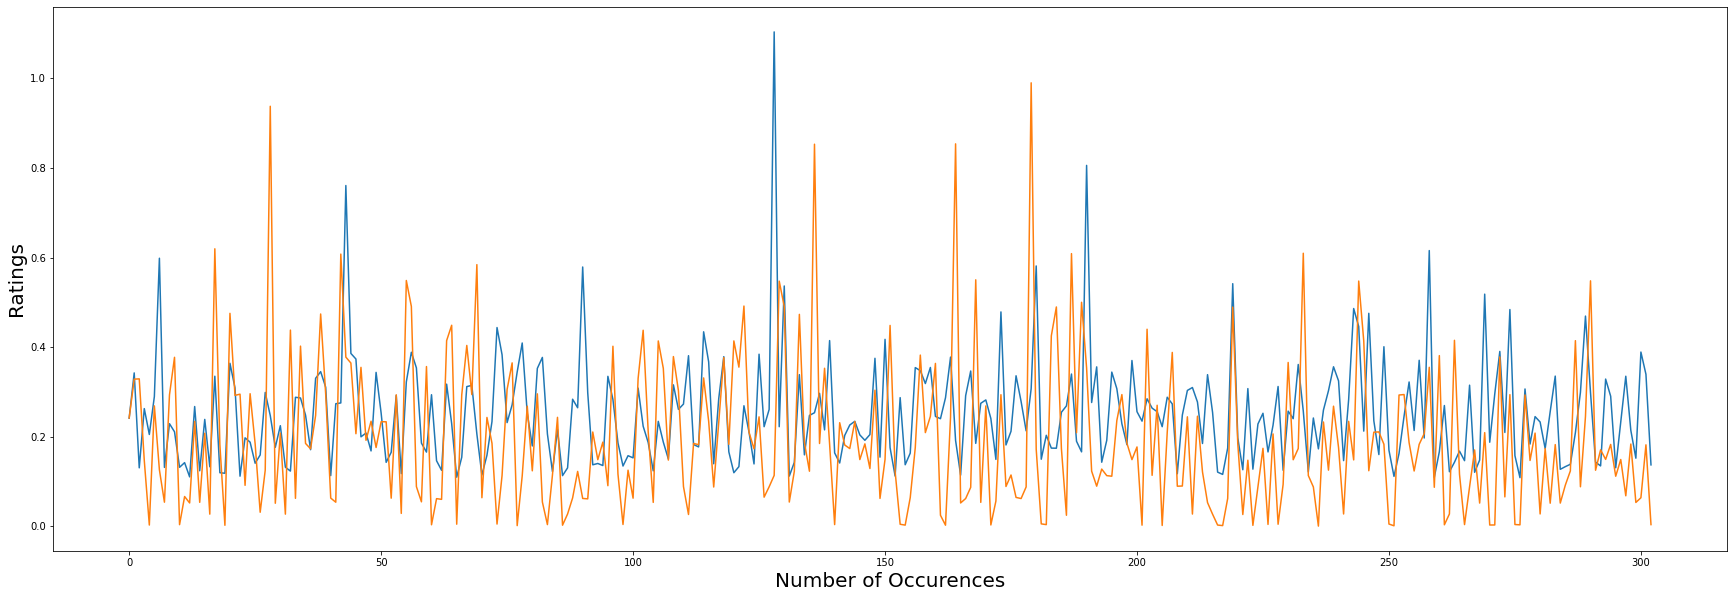

In [168]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calcualting the MSE of international bowling model

In [169]:
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test)

In [170]:
print('MSE of International bowling model is', mse)

MSE of International bowling model is 0.037348814
